# Variational Logistic Regression


Let $\mathcal{D} = \{({\bf x}_n, t_n) | {\bf x}_n \in \mathbb{R}^M, t_n \in \{0, 1\}\}_{n=1}^N$ be a database. We want to model the target variable $t$ conditioned on ${\bf x}$ as $t|{\bf x} \sim \text{Blli}\left(\sigma({\bf w}^T{\bf \phi({\bf x})})\right)$.


In the variational framework, we seek to maximize a lower bound on the marginal likelihood given by

$$
    p({\bf t}) = \int \left[\prod_{n=1}^N p(t_n | {\bf w})\right] p({\bf w}) d{\bf w}
$$

This notebook explains why and provides additional information in regards to the implementation of the model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, det
from numpy.random import seed, random

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (8, 4)

A lower bound on the joint distribution $p({\bf t}, {\bf w})$ is given by
$$
    p({\bf t}, {\bf w}) = p({\bf t}, {\bf w})p({\bf w}) \geq h({\bf w}, \boldsymbol{\varepsilon})
$$

Where the lower bound $h$ is given by

$$
    h({\bf w}, \boldsymbol{\varepsilon}) = \prod_{n=1}^N \sigma(\varepsilon_n)\exp\left({\bf w}^T{\boldsymbol \phi}_nt_n - ({\bf w}^T{\boldsymbol \phi}_n + \varepsilon_n) / 2 - \lambda(\varepsilon_n)\left([{\bf w}^T{\boldsymbol \phi}_n]^2 - \varepsilon^2\right)\right)
$$

and
$$
    \lambda(\varepsilon) = \frac{1}{2\varepsilon}\left[\sigma(\varepsilon) - \frac{1}{2}\right].
$$

Normalizing the joint distribution $p({\bf t}, {\bf w})$ would allow us to find the **true** posterior distribution $p({\bf w} | {\bf t})$. This, however, is intractable. In order to approximate the true posterior $p({\bf w} | {\bf t})$ **we normalize lower bound** $h$ and find a variational approximation $q({\bf w})$ given by

$$
\color{crimson}{
    q({\bf w}) = \mathcal{N}({\bf w} | {\bf m}_N, {\bf S}_N)
}
$$

With

$$
\begin{aligned}
    {\bf S}_N^{-1} &= {\bf S}_0 + 2 \sum_{n=1}^N \lambda(\varepsilon_n){\boldsymbol \phi}_n{\boldsymbol \phi}_n^T \\
    {\bf m}_N &= {\bf S}_N\left({\bf S}_0 {\bf m}_0 + \sum_{n=1}^N {\boldsymbol \phi}_n \left(t_n - \frac{1}{2}\right)\right)
\end{aligned}
$$

> The additional flexibility provided by the variational parameters $\{\varepsilon_n\}_{n=1}^N$ leads an improved accuracy [over the Laplacian method] in the approximation.

## Optimizing the variational parameters $\{\varepsilon_n\}_{n=1}^N$
In order to find the **best** variational lower-bound approximation $\color{crimson}{q({\bf w})}$ possible, we must determine the set $\{\varepsilon_n\}_n$ such that **maximize the lower bound on the marginal likelihood** $p({\bf t})$. Due to the monotonically increasing property of the $\log$ function, we note that the following inequality holds:

$$
    \log p({\bf t}, {\bf w}) \geq \log h({\bf w}, \boldsymbol{\varepsilon})
$$

It follows that 

$$
    \log p({\bf t}) \geq \log \int h({\bf w}, \boldsymbol{\varepsilon}) p({\bf w}) d{\bf w} = \mathcal{L}(\varepsilon)
$$

Thefore, we seek to maximize the lower bound on the log-model-evidence $\mathcal{L}(\varepsilon)$

### The EM Way


1. Choose initial values for ${\boldsymbol \varepsilon}^{(old)}$
2. **E-Step**: Evaluate the variational posterior $q({\bf w} | t, {\boldsymbol \varepsilon}^{(old)})$ (of "latent" variables")
3. **M-Step**: Obtain ${\boldsymbol \varepsilon}^{(new)}$ by updating
$$
    {\boldsymbol \varepsilon}^{(new)} = \arg\max_{{\boldsymbol \varepsilon}} \mathcal{Q}({\boldsymbol \varepsilon}, {\boldsymbol \varepsilon}^{(old)}) = \left({\boldsymbol \phi}_n^T ({\bf S}_n + {\bf m}_N{\bf m}_N^T) {\boldsymbol \phi}_n\right)^{1/2}
$$

4. Check for convergence by evaluating the lower-bound $\mathcal{L}({\boldsymbol \varepsilon}_n)$ given by

$$
    \mathcal{L}({\boldsymbol \varepsilon}_n) = \frac{1}{2}\log\frac{\vert{\bf S}_N\vert}{\vert{\bf S}_0\vert} + \frac{1}{2}{\bf m}_N^T {\bf S}^{-1}_N{\bf m}_N - \frac{1}{2}{\bf m}_0^T {\bf S}^{-1}_0{\bf m}_0 + \sum_{n=1}^N\left(\log\sigma(\varepsilon_n) - \varepsilon_n / 2 + \lambda(\varepsilon_n)\varepsilon_n^2 \right)
$$

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def lambdaf(eps):
    return (sigmoid(eps) - 1/2) / (2 * eps)

def df(f, x, eps=1e-6):
    return (f(x + eps) - f(x - eps)) / (2 * eps)

def plot_surface(X, f, step=0.05, include_bias=True):
    step = 0.05
    xmin, xmax = X[:, 0].min(), X[:, 0].max()
    ymin, ymax = X[:, 1].min(), X[:, 1].max()
    D = np.mgrid[xmin:xmax:step, ymin:ymax:step]
    D = np.concatenate((np.ones((1, D.shape[1], D.shape[2])), D), axis=0)
    Z = np.apply_along_axis(f, 0, D)
    
    plt.contourf(*D[1:], Z)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

def lower_bound(mN, m0, SN, S0, epsilon):
    E1 = np.log(det(SN) / det(S0)) / 2 + mN.T @ inv(SN) @ mN / 2 - m0.T @ inv(S0) @ m0 / 2
    E2 = (np.log(sigmoid(epsilon)) - epsilon / 2 + lambdaf(epsilon) * epsilon ** 2).sum()
    return (E1 + E2).item()

def kappa(sigma):
    return 1 / np.sqrt(1 + np.pi * sigma / 8)

def predictive_density(X, w, S):
    # Wmap @ Phi
    mu_a = np.einsum("imn,ij->mn", D, mN)
    # Phi.T @ SN @ Phi eske
    sigma_a = np.einsum("jmnk,jk,kmnj->mn", D[..., None], SN, D[..., None])
    p = sigmoid(kappa(sigma_a) * mu_a)
    return p

## Example

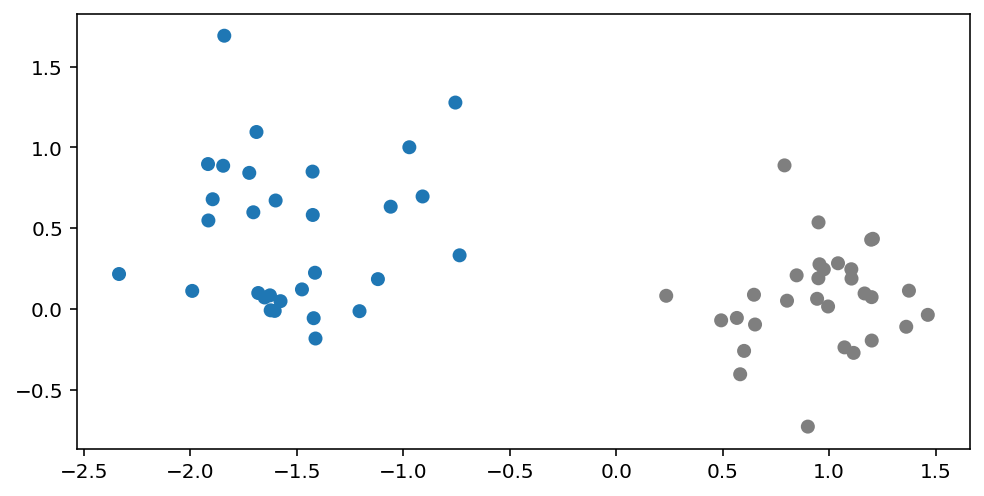

In [4]:
from scipy.stats import multivariate_normal

sigma1 = 0.2
sigma2 = 0.1
S1 = np.identity(2) * sigma1
S2 = np.identity(2) * sigma2

N1 = multivariate_normal(mean=[-1.5, 0.5], cov=S1)
N2 = multivariate_normal(mean=[1, 0], cov=S2)

nsamples = 30
X1 = N1.rvs(size=nsamples, random_state=314)
X2 = N2.rvs(size=nsamples, random_state=3141)

X = np.r_[X1, X2]
y = np.r_[np.ones(nsamples), np.zeros(nsamples)]
colors = ["tab:blue" if yi == 1 else "tab:gray" for yi in y]
plt.scatter(*X.T, c=colors)

Phi = np.c_[np.ones_like(y), X]

### Evaluating $q({\bf w})$

$$
\begin{aligned}
    {\bf S}_N^{-1} &= {\bf S}_0 + 2 \sum_{n=1}^N \lambda(\varepsilon_n){\boldsymbol \phi}_n{\boldsymbol \phi}_n^T \\
    {\bf m}_N &= {\bf S}_N\left({\bf S}_0 {\bf m}_0 + \sum_{n=1}^N {\boldsymbol \phi}_n \left(t_n - \frac{1}{2}\right)\right)
\end{aligned}
$$

In [5]:
seed(314)
epsilon = random(Phi.shape[0])

sigma = 0.5
S0 = np.identity(Phi.shape[-1]) * sigma
m0 = np.zeros(Phi.shape[-1]).reshape(-1, 1)

In [6]:
SN = inv(inv(S0) + 2 * (lambdaf(epsilon)[:, np.newaxis] * Phi).T @ Phi)
mN = SN @ (inv(S0) @ m0 + (Phi.T * (y - 1/2)[None, :]).sum(axis=1, keepdims=True))

In [7]:
q = multivariate_normal(mean=mN.ravel(), cov=SN)

In [8]:
step = 0.01
xmin, xmax = X[:, 0].min() - 1, X[:, 0].max() + 1
ymin, ymax = X[:, 1].min() - 1, X[:, 1].max() + 1
D = np.mgrid[xmin:xmax:step, ymin:ymax:step]
D = np.concatenate((np.ones((1, D.shape[1], D.shape[2])), D), axis=0)

In [9]:
p = predictive_density(D, mN, SN)

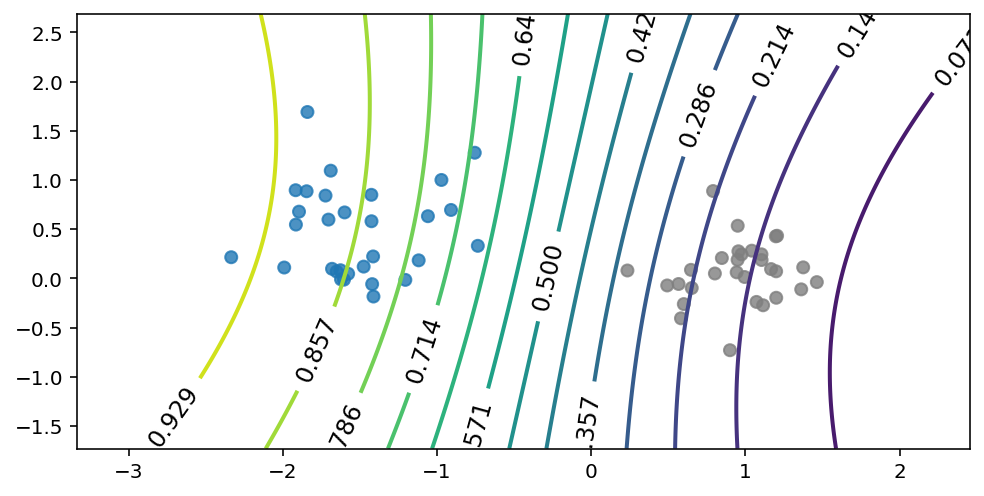

In [10]:
levels = np.linspace(0, 1, 15)
labs = plt.contour(*D[1:], p, linewidths=2, levels=levels)
plt.clabel(labs, fontsize=12, colors="black")
plt.scatter(*X.T, c=colors, alpha=0.8);

In [11]:
L = lower_bound(mN, m0, SN, S0, epsilon)

### Updating $\varepsilon$

$$
    {\boldsymbol \varepsilon}^{(new)}_n = \left({\boldsymbol \phi}_n^T ({\bf S}_N + {\bf m}_N{\bf m}_N^T) {\boldsymbol \phi}_n\right)^{1/2}
$$

In [12]:
L_hist = [L]

convergence = False
while not convergence:
    epsilon = np.sqrt(np.diag(Phi @ (SN + mN @ mN.T) @ Phi.T))
    SN = inv(S0 + 2 * (lambdaf(epsilon)[:, np.newaxis] * Phi).T @ Phi)
    mN = SN @ (S0 @ m0 + (Phi.T * (y - 1/2)[None, :]).sum(axis=1, keepdims=True))
    L = lower_bound(mN, m0, SN, S0, epsilon)
    if abs(L / L_hist[-1] - 1) < 1e-5:
        convergence = True
    L_hist.append(L)

In [13]:
p = predictive_density(D, mN, SN)

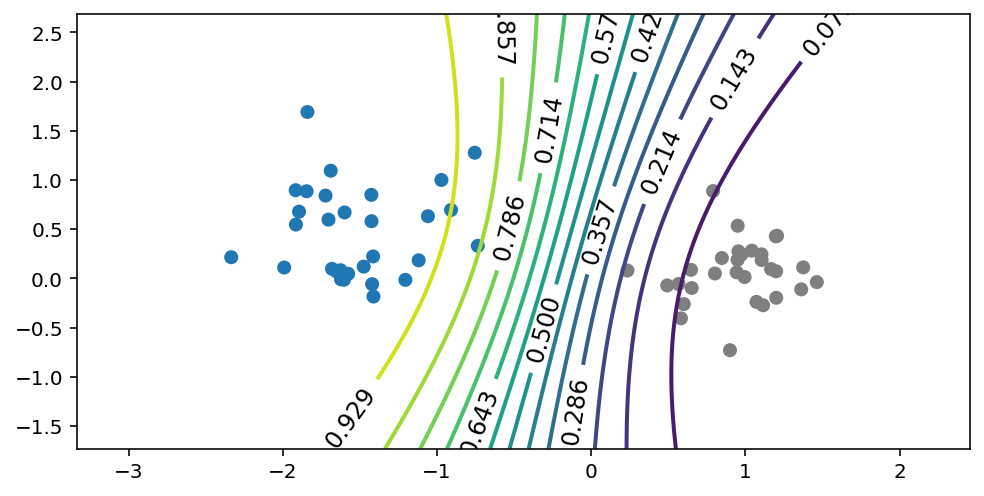

In [14]:
labs = plt.contour(*D[1:], p, linewidths=2, levels=levels)
plt.clabel(labs, fontsize=12, colors="black")

plt.scatter(*X.T, c=colors)

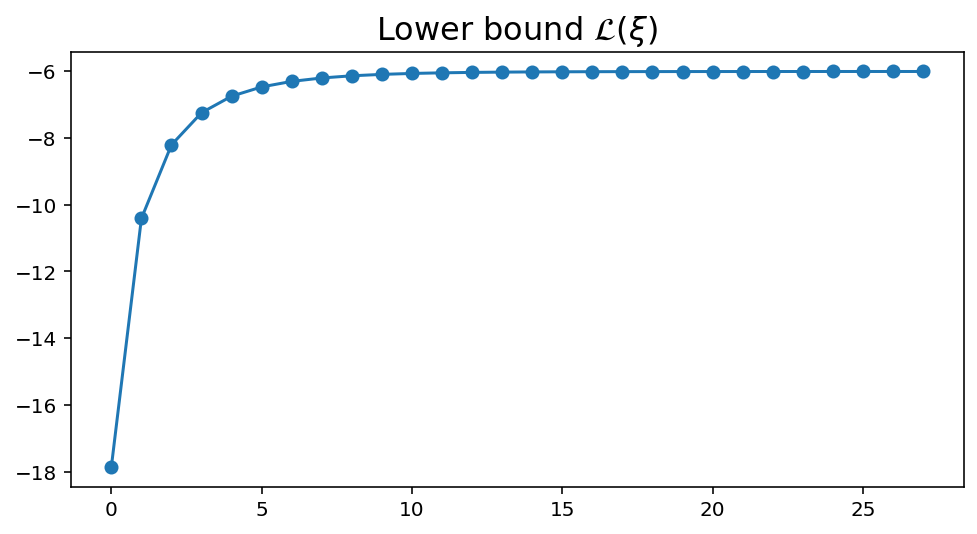

In [15]:
plt.plot(L_hist, marker="o")
plt.title(r"Lower bound $\mathcal{L}(\xi)$", fontsize=16);